## First attempt for predicting housing prices.

### 1. Exploratory data analysis

In [1]:
# import necessary libraries and load the data
import numpy as np
import pandas as pd

train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
# Drop Id feature, since it is not related.
test_id = test_df['Id']
train_df.drop('Id', axis = 1, inplace = True)
test_df.drop('Id', axis = 1, inplace = True)
# take a breif look at the data
print(train_df.head())
train_df.describe()
print(train_df.shape)

   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig    ...     PoolArea PoolQC Fence  \
0         Lvl    AllPub    Inside    ...            0    NaN   NaN   
1         Lvl    AllPub       FR2    ...            0    NaN   NaN   
2         Lvl    AllPub    Inside    ...            0    NaN   NaN   
3         Lvl    AllPub    Corner    ...            0    NaN   NaN   
4         Lvl    AllPub       FR2    ...            0    NaN   NaN   

  MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0         NaN       0      2    2008        WD         Normal     208500  
1       

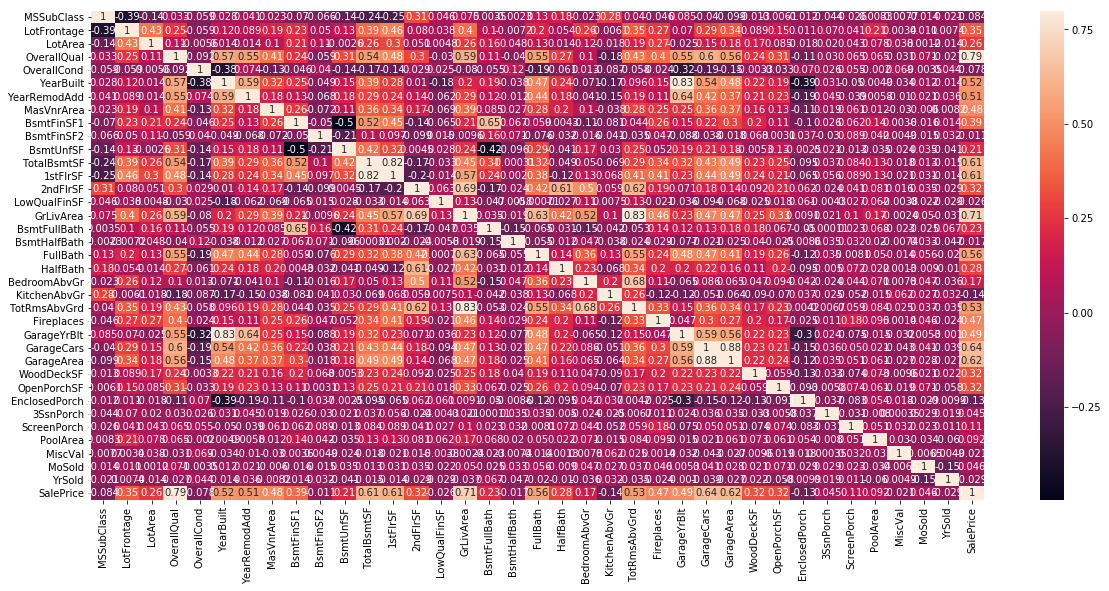

In [2]:
# visualize the correlations among features
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

corrmat = train_df.corr()  # calculate the correlations
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=.8, annot=True)  # produce heatmap 

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd'],
      dtype='object')
OverallQual


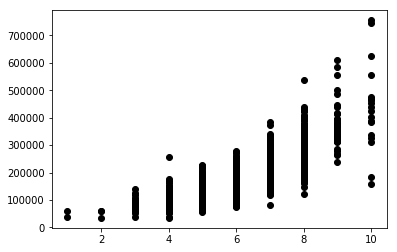

GrLivArea


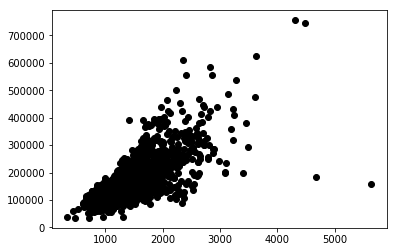

GarageCars


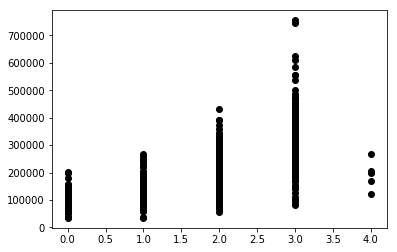

GarageArea


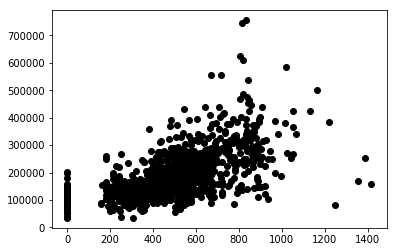

TotalBsmtSF


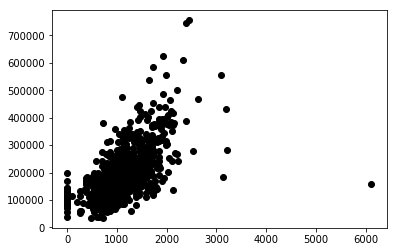

1stFlrSF


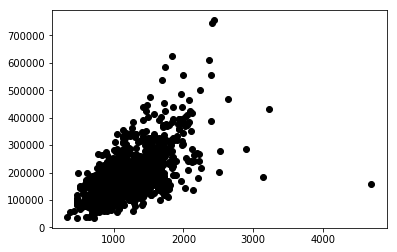

FullBath


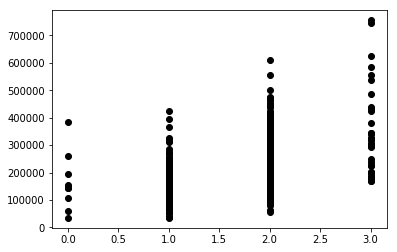

TotRmsAbvGrd


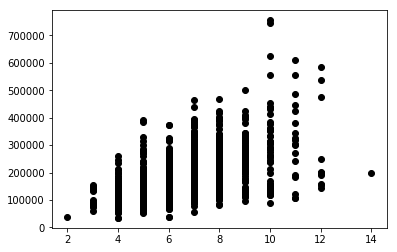

YearBuilt


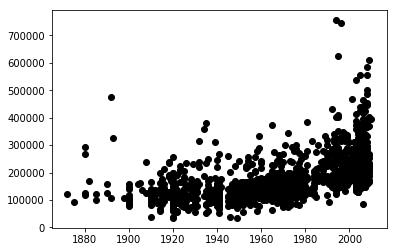

YearRemodAdd


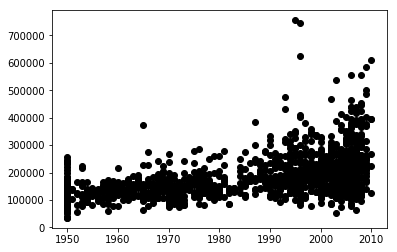

In [4]:
corrmat['SalePrice'][abs(corrmat['SalePrice']) > 0.5].sort_values()
most_related_features = corrmat['SalePrice'][abs(corrmat['SalePrice']) > 0.5].sort_values(ascending=False).index
print(most_related_features)
for f in range(1, len(most_related_features)):
    print(most_related_features[f])
    plt.scatter(y = train_df['SalePrice'],x = train_df[most_related_features[f]],c = 'black')
    plt.show()

In [5]:
# Get rid of outliers
# (1) get rid of the two samples in GrLivArea that more than 4000 sf and less than 220000 dollars
print(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<220000)].index)
train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<220000)].index, inplace=True)

# (2) get rid of the 4 samples in GarageArea where they are more than 1200 and less than 300000 dollars.
print(train_df[(train_df['GarageArea']>1200) & (train_df['SalePrice']<300000)].index)
train_df.drop(train_df[(train_df['GarageArea']>1200) & (train_df['SalePrice']<300000)].index, inplace=True)

# (3) get rid of the 1 sample in TotalBasmtSF where it is more than 6000 sf.
print(train_df[(train_df['TotalBsmtSF']>6000)].index)
train_df.drop(train_df[(train_df['TotalBsmtSF']>6000)].index, inplace=True)

# (4) get rid of the 1 sample in 1stFlrSF where it is more than 4000 sf.
print(train_df[(train_df['1stFlrSF']>4000)].index)
train_df.drop(train_df[(train_df['1stFlrSF']>4000)].index, inplace=True)


Int64Index([523, 1298], dtype='int64')
Int64Index([581, 1061, 1190], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


In [6]:
train_df.shape

(1455, 80)

We also need to check the distribution of the target SalePrice. If they are not well distributed, we need to take some actions.

/home/han/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 180960.76 and sigma = 79483.16



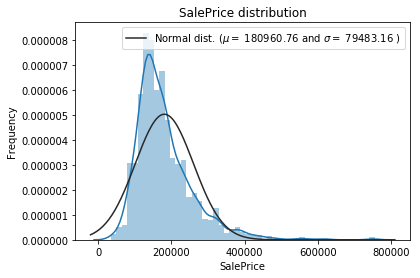

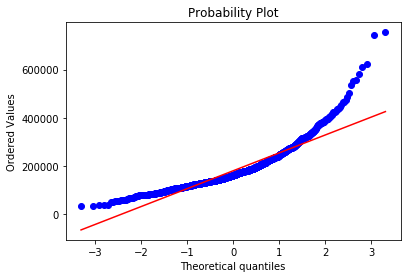

In [7]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

sns.distplot(train_df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

/home/han/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 12.02 and sigma = 0.40



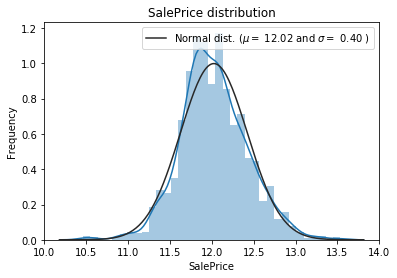

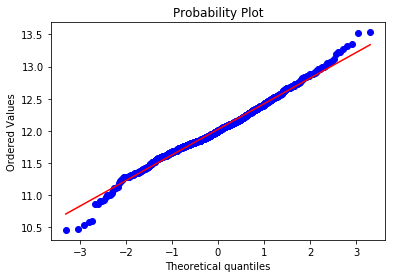

In [34]:
# Take log of the target values to prevent skewness
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])
y_train = train_df["SalePrice"]

#Check the new distribution 
sns.distplot(train_df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()


### 2. Next, we need to clean the data, do some necessary feature engineering, and preprocess data.

(1) Data cleaning:
    a. Detect if there are some abnormal data (e.g. negative value, no value).
    b. Some NA values mean No in some columns.
    c. For abnormal negative values, we can use some statistical methods to fill values.
    d. For string values, we need to convert them into one-hot encoding.
    e. For some number values llike years, we need to put them into bins (windows).

In [10]:
y_train = train_df["SalePrice"].values
num_train = train_df.shape[0]
num_test = test_df.shape[0]
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
for c in all_data.columns:
    num_na = all_data[c].isnull().sum()
    if num_na > 0 and all_data[c].dtype != object:
        print('column', c, 'has', str(num_na), 'null values.')
all_data.head()

column BsmtFinSF1 has 1 null values.
column BsmtFinSF2 has 1 null values.
column BsmtFullBath has 2 null values.
column BsmtHalfBath has 2 null values.
column BsmtUnfSF has 1 null values.
column GarageArea has 1 null values.
column GarageCars has 1 null values.
column GarageYrBlt has 159 null values.
column LotFrontage has 485 null values.
column MasVnrArea has 23 null values.
column TotalBsmtSF has 1 null values.


/home/han/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType BsmtCond  \
0       856       854          0   NaN             3     1Fam       TA   
1      1262         0          0   NaN             3     1Fam       TA   
2       920       866          0   NaN             3     1Fam       TA   
3       961       756          0   NaN             3     1Fam       Gd   
4      1145      1053          0   NaN             4     1Fam       TA   

  BsmtExposure  BsmtFinSF1  BsmtFinSF2  ...   SaleType ScreenPorch  Street  \
0           No       706.0         0.0  ...         WD           0    Pave   
1           Gd       978.0         0.0  ...         WD           0    Pave   
2           Mn       486.0         0.0  ...         WD           0    Pave   
3           No       216.0         0.0  ...         WD           0    Pave   
4           Av       655.0         0.0  ...         WD           0    Pave   

   TotRmsAbvGrd TotalBsmtSF  Utilities WoodDeckSF YearBuilt YearRemodAdd  \
0             8       856.0     AllPub          0      2003         2003   
1             6      1262.0     AllPub        298      1976         1976   
2             6       920.0     AllPub          0      2001         2002   
3             7       756.0     AllPub          0      1915         1970   
4             9      1145.0     AllPub        192      2000         2000   

  YrSold  
0   2008  
1   2007  
2   2008  
3   2006  
4   2008  

[5 rows x 79 columns]

If a column with just 1 or 2 null values, fill them will the average values.

In [16]:
all_data['BsmtFinSF1'] = all_data['BsmtFinSF1'].fillna(all_data['BsmtFinSF1'].mean())
all_data['BsmtFinSF2'] = all_data['BsmtFinSF2'].fillna(all_data['BsmtFinSF2'].mean())
all_data['BsmtFullBath'] = all_data['BsmtFullBath'].fillna(all_data['BsmtFullBath'].mean())
all_data['BsmtHalfBath'] = all_data['BsmtHalfBath'].fillna(all_data['BsmtHalfBath'].mean())
all_data['BsmtUnfSF'] = all_data['BsmtUnfSF'].fillna(all_data['BsmtUnfSF'].mean())
all_data['GarageArea'] = all_data['GarageArea'].fillna(all_data['GarageArea'].mean())
all_data['GarageCars'] = all_data['GarageCars'].fillna(all_data['GarageCars'].mean())
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].fillna(all_data['TotalBsmtSF'].mean())

Found 3 columns have abnormal null values for numerical columns. We can use a statistical way to handle this, e.g. use the mean of similar data.<br>
LotFrontage means the linear feed from a street. If value is null, we can use the mean or interpolation of the lot area size to fill values here.<br>
MasVnrArea means the masonry veneer area. We can use the mean of the area size of the same type of masonary to replace NA values. <br>
GarageYrBlt means the year that the garage been built. We can use mean of the same type of garage to fill the values for them. <br>

In [17]:
# Check the LotFrontage column and interpolate the value with linear relationship with lot area size.
# pd.isnull(raw_df['LotFrontage'][7])
la_max, la_min = all_data['LotArea'].max(), all_data['LotArea'].min()
lf_max, lf_min = all_data['LotFrontage'].max(), all_data['LotFrontage'].min()
lf_df = all_data['LotFrontage'].copy()
for i in range(lf_df.size):
    if pd.isnull(lf_df[i]):
        lf_df[i] = ((all_data['LotArea'][i] - la_min) / (la_max - la_min))*(lf_max - lf_min) + lf_min

lf_df.describe()

count    2914.000000
mean       63.641769
std        25.175722
min        21.000000
25%        45.001870
50%        63.000000
75%        79.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [18]:
# check MasVnrArea and fill the NA values with mean values
mvt_mean = all_data[['MasVnrType', 'MasVnrArea']].groupby('MasVnrType').mean()
all_mvt_mean = all_data['MasVnrArea'].mean()
# print(mv_max)
# print(mv_min)
# print(mv_mean)

mva_df = all_data['MasVnrArea'].copy()
for j in range(mva_df.size):
    if pd.isnull(mva_df[j]):
        if all_data['MasVnrType'][j] in mvt_mean.index:
            mva_df[j] = mvt_mean.iloc(all_data['MasVnrType'][j])[0]
        else:
            mva_df[j] = all_mvt_mean

print(mva_df.describe())

count    2914.000000
mean      101.681771
std       177.844014
min         0.000000
25%         0.000000
50%         0.000000
75%       162.750000
max      1600.000000
Name: MasVnrArea, dtype: float64


In [19]:
# check the GarageYrBlt column and use the average year of the same type to estimate the values for NA locations
all_data['GarageYrBlt'].describe()
sum(all_data['GarageYrBlt'].isnull() == all_data['GarageType'].isnull())
# The NA values in GarageType match the NA values in GarageYrBlt. 
# I can use the min value to replace NA values in GarageYrBlt.
gyb_min = all_data['GarageYrBlt'].min()
gyb_df = all_data['GarageYrBlt'].copy().fillna(gyb_min)
print(gyb_df.describe())

count    2914.000000
mean     1973.543240
std        31.218789
min      1895.000000
25%      1957.000000
50%      1977.000000
75%      2001.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64


(2) Feature Engineering
    a. We can create some new features if they can be helpful.

One obvious new feature that we can add is the total square feet by adding 1stFlrSF, 2ndFlrSF, and TotalBsmtSF.

In [20]:
total_square_feet = all_data['1stFlrSF'] + all_data['2ndFlrSF'] + all_data['TotalBsmtSF']
total_square_feet.describe()

count     2914.000000
mean      2542.498961
std        780.285370
min        334.000000
25%       2000.000000
50%       2447.000000
75%       2990.000000
max      10190.000000
dtype: float64

(3) Preprocess data:
    Scale data between 0 and 1 for numerical values.
    Convert non-numerical values into one-hot encoding.
    Split data into training and testing parts.

In [21]:
# Get all numerical values and scale them between [0, 1].
processed_df = all_data.copy()
# replace some data by the aboved cleaned data
processed_df['LotFrontage'] = lf_df
processed_df['MasVnrArea'] = mva_df
processed_df['GarageYrBlt'] = gyb_df
# get all nuerical values
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
processed_numerical_df = processed_df.select_dtypes(include=numerics)
# processed_numerical_df.describe()
# y_df = processed_numerical_df['SalePrice']
# processed_numerical_df = processed_numerical_df.drop(columns=['SalePrice'], axis=1)
processed_numerical_df.head()

1stFlrSF  2ndFlrSF  3SsnPorch  BedroomAbvGr  BsmtFinSF1  BsmtFinSF2  \
0       856       854          0             3       706.0         0.0   
1      1262         0          0             3       978.0         0.0   
2       920       866          0             3       486.0         0.0   
3       961       756          0             3       216.0         0.0   
4      1145      1053          0             4       655.0         0.0   

   BsmtFullBath  BsmtHalfBath  BsmtUnfSF  EnclosedPorch   ...    OverallCond  \
0           1.0           0.0      150.0              0   ...              5   
1           0.0           1.0      284.0              0   ...              8   
2           1.0           0.0      434.0              0   ...              5   
3           1.0           0.0      540.0            272   ...              5   
4           1.0           0.0      490.0              0   ...              5   

   OverallQual  PoolArea  ScreenPorch  TotRmsAbvGrd  TotalBsmtSF  WoodDeckSF  \
0            7         0            0             8        856.0           0   
1            6         0            0             6       1262.0         298   
2            7         0            0             6        920.0           0   
3            7         0            0             7        756.0           0   
4            8         0            0             9       1145.0         192   

   YearBuilt  YearRemodAdd  YrSold  
0       2003          2003    2008  
1       1976          1976    2007  
2       2001          2002    2008  
3       1915          1970    2006  
4       2000          2000    2008  

[5 rows x 36 columns]

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
processed_numerical_df = pd.DataFrame(scaler.fit_transform(processed_numerical_df), columns=processed_numerical_df.columns)
print(processed_numerical_df.describe())
numerical_data = processed_numerical_df.values
print(numerical_data.shape)

          1stFlrSF     2ndFlrSF    3SsnPorch  BedroomAbvGr   BsmtFinSF1  \
count  2914.000000  2914.000000  2914.000000   2914.000000  2914.000000   
mean      0.172930     0.162812     0.005131      0.357541     0.109494   
std       0.080863     0.207363     0.049625      0.102904     0.110720   
min       0.000000     0.000000     0.000000      0.000000     0.000000   
25%       0.113842     0.000000     0.000000      0.250000     0.000000   
50%       0.157110     0.000000     0.000000      0.375000     0.091895   
75%       0.220489     0.340920     0.000000      0.375000     0.182731   
max       1.000000     1.000000     1.000000      1.000000     1.000000   

        BsmtFinSF2  BsmtFullBath  BsmtHalfBath    BsmtUnfSF  EnclosedPorch  \
count  2914.000000   2914.000000   2914.000000  2914.000000    2914.000000   
mean      0.032547      0.143086      0.030735     0.239826       0.022864   
std       0.110950      0.174622      0.122900     0.187849       0.063530   
min       0.

/home/han/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [23]:
# handle non-numerical values
non_numerics = ['object']
processed_object_df = processed_df.select_dtypes(include=non_numerics)
processed_object_df.head()
temp_holder = []

for column in processed_object_df.columns:
    # for each column, convert to one-hot encoding, add to the holder
    temp_df = pd.get_dummies(processed_object_df[column])
    temp_holder.append(temp_df.values)

# temp_holder = np.asarray(temp_holder)
categorical_data = np.concatenate(temp_holder, axis=1)
print(categorical_data.shape)

(2914, 251)


In [35]:
# combine numerical data and categorical data
x = np.concatenate([numerical_data, categorical_data], axis=1)
x_train, x_test = x[:num_train], x[num_train:]
# y = y_train
print(x.shape)
print(y.shape)
print(y_train[:10])

(2914, 287)
(1455,)
0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
5    11.870607
6    12.634606
7    12.206078
8    11.774528
9    11.678448
Name: SalePrice, dtype: float64


In [45]:
# split data into training and testing two parts
# from sklearn.model_selection import train_test_split

# x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1)
print(x_train.shape)
print(y_train.shape)
print(x_train[:10])
print(y_train[:10])

(1455, 287)
(1455,)
[[0.10964083 0.41355932 0.         ... 1.         1.         0.        ]
 [0.19491703 0.         0.         ... 1.         1.         0.        ]
 [0.12308339 0.41937046 0.         ... 1.         1.         0.        ]
 ...
 [0.16236085 0.47602906 0.         ... 1.         1.         0.        ]
 [0.14450746 0.36416465 0.         ... 1.         1.         0.        ]
 [0.15605965 0.         0.         ... 1.         1.         0.        ]]
0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
5    11.870607
6    12.634606
7    12.206078
8    11.774528
9    11.678448
Name: SalePrice, dtype: float64


### 3. Build the model

(1) Base model: Linear regression. It will serve as a benchmark to beat.

In [46]:
# build the linear regression model and find the best hyperparameters by using grid_search
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg_model = LinearRegression()
reg_model.fit(x_train, y_train)
predicted_y = reg_model.predict(x_train)
reg_mse = mean_squared_error(y_train, predicted_y)
print('Linear Regression model MSE is', reg_mse)   # get the mse for the linear regression model

Linear Regression model MSE is 0.00812395115189583


(2) A single model: random forest, xgboost, svm regressor, FNN regressor

In [47]:
# First, try a random forest regressor.
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
rf_model = RandomForestRegressor()
rf_clf = GridSearchCV(rf_model, parameters, cv=5, scoring='neg_mean_squared_error')
rf_clf.fit(x_train, y_train)
final_rf_model = rf_clf.best_estimator_
print(rf_clf.best_params_)

predicted_y_rf = final_rf_model.predict(x_train)
rf_mse = mean_squared_error(y_train, predicted_y_rf)
print('Random Forest model MSE is', rf_mse)   # get the mse for the random forest model

{'n_estimators': 90}
Random Forest model MSE is 0.0025948878915314126


In [48]:
# Second, try a xgboost regressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

dtrain = xgb.DMatrix(x_train, label=y_train)

xgb_parameters = {
    'eta': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    'booster': ['gbtree', 'gblinear', 'dart']
}
xgb_regressor = XGBRegressor()
xgb_clf = GridSearchCV(xgb_regressor, xgb_parameters, cv=5, scoring='neg_mean_squared_error')
xgb_clf.fit(x_train, y_train)
final_xgb_model = xgb_clf.best_estimator_
print(xgb_clf.best_params_)

predicted_y_xgb = final_xgb_model.predict(x_train)
xgb_mse = mean_squared_error(y_train, predicted_y_xgb)
print('XGB model MSE is', xgb_mse)   # get the mse for the XGBoost model

{'booster': 'dart', 'eta': 0.01}
XGB model MSE is 0.00746443302276106


In [49]:
# Try a FNN regressor by Keras or SKlearn
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

mlp_parameters = {
    'hidden_layer_sizes':[(100,), (200,), (300,)],
    'activation':['logistic', 'tanh'],
    'solver': ['adam'],
    'learning_rate':['adaptive'],
    'learning_rate_init':[0.001, 0.01, 0.1],
    'max_iter':[200, 300, 400],
    'early_stopping':[True]
}

fnn_model = MLPRegressor()
fnn_clf = GridSearchCV(fnn_model, mlp_parameters, cv=5, scoring='neg_mean_squared_error')
fnn_clf.fit(x_train, y_train)
final_fnn_model = fnn_clf.best_estimator_
print(fnn_clf.best_params_)

predicted_y_fnn = final_fnn_model.predict(x_train)
fnn_mse = mean_squared_error(y_train, predicted_y_fnn)
print('FNN model MSE is', fnn_mse)   # get the mse for the FNN model

/home/han/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/han/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/han/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/han/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % sel

/home/han/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/han/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/han/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/han/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % sel

{'activation': 'tanh', 'early_stopping': True, 'hidden_layer_sizes': (300,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 200, 'solver': 'adam'}
FNN model MSE is 0.020095735249386043


In [ ]:
# Try a BoostingGradientRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

gbr_parameters = {
    'loss':['ls', 'lad', 'huber', 'quantile'],
    'learning_rate':[0.001, 0.01, 0.1],
    'n_estimators': [80, 90, 100, 110, 120],
    'max_depth':[3,4,5],
}

gbr_model = GradientBoostingRegressor()
gbr_clf = GridSearchCV(gbr_model, gbr_parameters, cv=5, scoring='neg_mean_squared_error')
gbr_clf.fit(x_train, y_train)
final_gbr_model = gbr_clf.best_estimator_
print(gbr_clf.best_params_)

predicted_y_gbr = final_gbr_model.predict(x_train)
gbr_mse = mean_squared_error(y_train, predicted_y_gbr)
print('GBR model MSE is', gbr_mse)   # get the mse for the GBR model

In [ ]:
# Try a Kernel Ridge Regressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

kr_parameters = {
    'alpha':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'kernel':['polynomial', 'linear'],
    'degree': [2, 3, 4, 5],
}

kr_model = KernelRidge()
kr_clf = GridSearchCV(kr_model, kr_parameters, cv=5, scoring='neg_mean_squared_error')
kr_clf.fit(x_train, y_train)
final_kr_model = kr_clf.best_estimator_
print(kr_clf.best_params_)

predicted_y_kr = final_kr_model.predict(x_train)
kr_mse = mean_squared_error(y_train, predicted_y_kr)
print('Kernal Ridge model MSE is', kr_mse)   # get the mse for the Kernal Ridge model

(3) try an emsemble model: random forst regressor, xgboost, FNN, gbr, kernal ridge

In [ ]:
class Combine_Models:
    def __init__(self, models):
        """
        models: a list of models already trained above
        """
        self.models = models
    
    def predict(self, test_data):
        """
        test_data: 2d array, dimension: number_samples x number_features
        """
        temp_holder = []
        for model in self.models:
            predicted_y = model.predict(test_data)
            temp_holder.append(predicted_y)
        final_predictions = np.mean(temp_holder, axis=1)
        return final_predictions

In [ ]:
model_list = [final_rf_model, final_fnn_model, final_xgb_model, final_gbr_model, final_kr_model]
ensemble_model = Combine_Models(model_list)
final_predictions = ensemble_model(x_test)
result = pd.DataFrame()
result['Id'] = test_id
result['SalePrice'] = final_predictions
result.to_csv('submission.csv',index=False)